# **Predictive Analytics 🔍 for Fraud Detection in Financial Transactions**
 - shubham parmar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [4]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# Handle missing values
data = data.dropna()

## Data Dictionary:

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amount** - amount of the transaction in local currency.

* **nameOrig** - customer who started the transaction

* **oldbalanceOrg** - initial balance before the transaction

* **newbalanceOrig** - new balance after the transaction

* **nameDest** - customer who is the recipient of the transaction

* **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


isFraud
0    6354407
1       8213
Name: count, dtype: int64


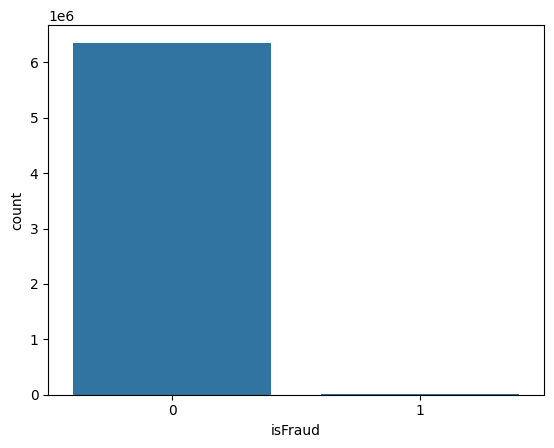

In [7]:
# Distribution of target variable
print(data['isFraud'].value_counts())
sns.countplot(x='isFraud', data=data)
plt.show()

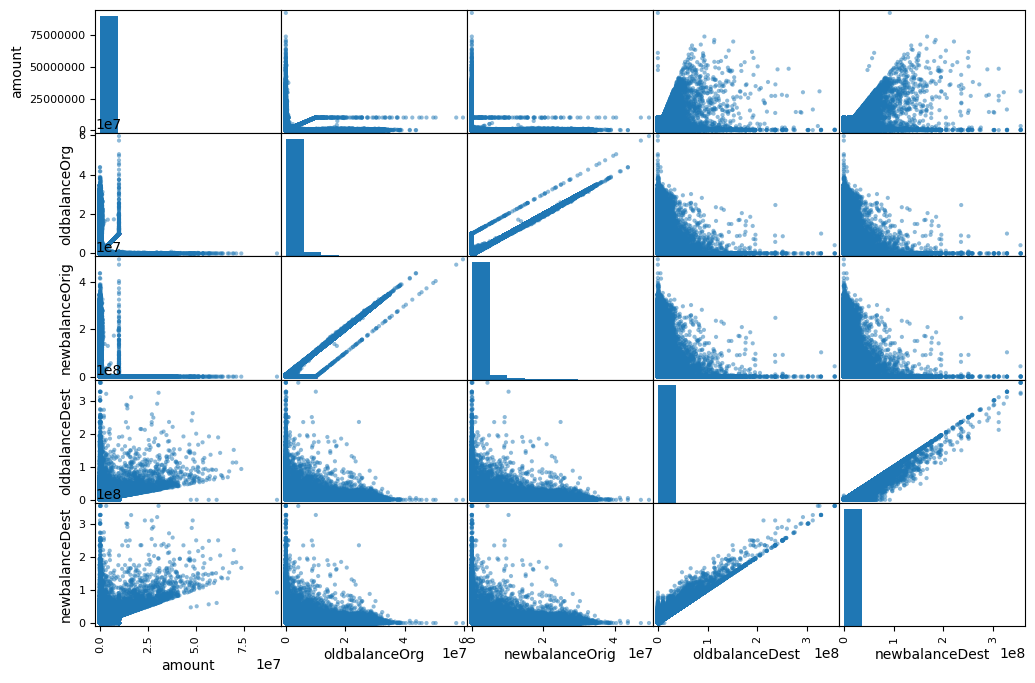

In [9]:
from pandas.plotting import scatter_matrix

scatter_matrix(data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']], figsize=(12, 8))
plt.show()

In [8]:
# Check for outliers
data = data[(np.abs(data['amount'] - data['amount'].mean()) <= (3*data['amount'].std()))]

In [9]:
# Remove outliers based on Z-score
data = data[(np.abs(stats.zscore(data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])) < 3).all(axis=1)]

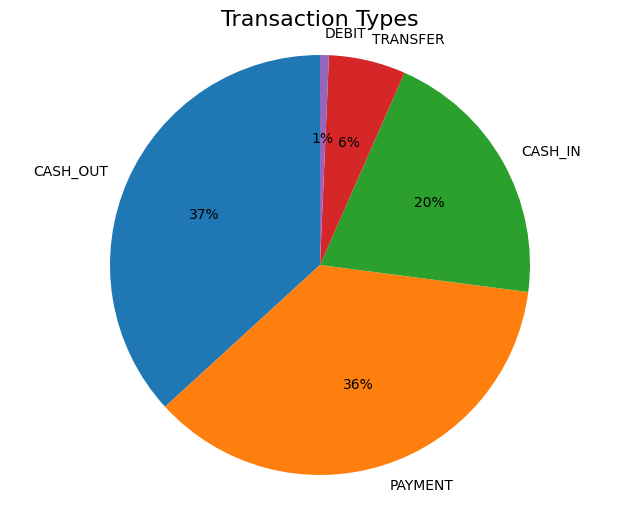

In [10]:
# Count the occurrences of each transaction type
type_counts = data['type'].value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(type_counts, labels=type_counts.index, autopct='%1.0f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is drawn as a circle
ax.set_title('Transaction Types', fontsize=16)

plt.show()

In [11]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,0
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,0
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0


In [12]:
# Check and handle multi-collinearity
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

In [13]:
features = data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
calculate_vif(features)

,variables,VIF
0,amount,2.525478
1,oldbalanceOrg,440.422193
2,newbalanceOrig,456.364555
3,oldbalanceDest,130.207657
4,newbalanceDest,138.188035


In [14]:
# Create the new columns (Feature Engineering)
data['orgDiff'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['destDiff'] = data['newbalanceDest'] - data['oldbalanceDest']

# Feature Engineering
data['amount_log'] = np.log(data['amount'] + 1)
data = pd.get_dummies(data, columns=['type']) # One-hot encoding for 'type'

In [15]:
data

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orgDiff,destDiff,amount_log,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,-9839.64,0.00,9.194276,False,False,False,True,False
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,-1864.28,0.00,7.531166,False,False,False,True,False
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,-181.00,0.00,5.204007,False,False,False,False,True
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,-181.00,-21182.00,5.204007,False,True,False,False,False
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,-11668.14,0.00,9.364703,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362609,742,258355.42,C1113162093,258355.42,0.00,C797688696,25176.67,283532.09,1,0,-258355.42,258355.42,12.462095,False,True,False,False,False
6362610,742,63416.99,C778071008,63416.99,0.00,C1812552860,0.00,0.00,1,0,-63416.99,0.00,11.057503,False,False,False,False,True
6362611,742,63416.99,C994950684,63416.99,0.00,C1662241365,276433.18,339850.17,1,0,-63416.99,63416.99,11.057503,False,True,False,False,False
6362614,743,339682.13,C2013999242,339682.13,0.00,C1850423904,0.00,0.00,1,0,-339682.13,0.00,12.735768,False,False,False,False,True


In [16]:
# Encode categorical columns
le_nameOrig = LabelEncoder()
le_nameDest = LabelEncoder()
data['nameOrig'] = le_nameOrig.fit_transform(data['nameOrig'])
data['nameDest'] = le_nameDest.fit_transform(data['nameDest'])

In [17]:
# Split data into train and test sets
X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Model Training
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print('Logistic Regression Metrics:')
print('Precision: ', precision_score(y_test, lr_pred))
print('Recall: ', recall_score(y_test, lr_pred))
print('F1-Score: ', f1_score(y_test, lr_pred))
print('AUC-ROC: ', roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

Logistic Regression Metrics:
Precision:  0.8366247755834829
Recall:  0.4678714859437751
F1-Score:  0.600128783000644
AUC-ROC:  0.9935363099880107


In [19]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print('Logistic Regression Metrics:')
print('Precision: ', precision_score(y_test, lr_pred))
print('Recall: ', recall_score(y_test, lr_pred))
print('F1-Score: ', f1_score(y_test, lr_pred))
print('AUC-ROC: ', roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

Logistic Regression Metrics:
Precision:  0.8366247755834829
Recall:  0.4678714859437751
F1-Score:  0.600128783000644
AUC-ROC:  0.9935363099880107


In [20]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print('Random Forest Metrics:')
print('Precision: ', precision_score(y_test, rf_pred))
print('Recall: ', recall_score(y_test, rf_pred))
print('F1-Score: ', f1_score(y_test, rf_pred))
print('AUC-ROC: ', roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

Random Forest Metrics:
Precision:  0.9641319942611191
Recall:  0.6746987951807228
F1-Score:  0.7938570584760779
AUC-ROC:  0.991815799101785


Feature importances:
                 importance
destDiff          0.180467
newbalanceDest    0.170724
orgDiff           0.135925
oldbalanceOrg     0.093878
step              0.086066
amount            0.066256
amount_log        0.064232
oldbalanceDest    0.063874
type_TRANSFER     0.042461
newbalanceOrig    0.033005
nameDest          0.023049
nameOrig          0.020551
type_CASH_OUT     0.015647
type_CASH_IN      0.002166
type_PAYMENT      0.001449
type_DEBIT        0.000251


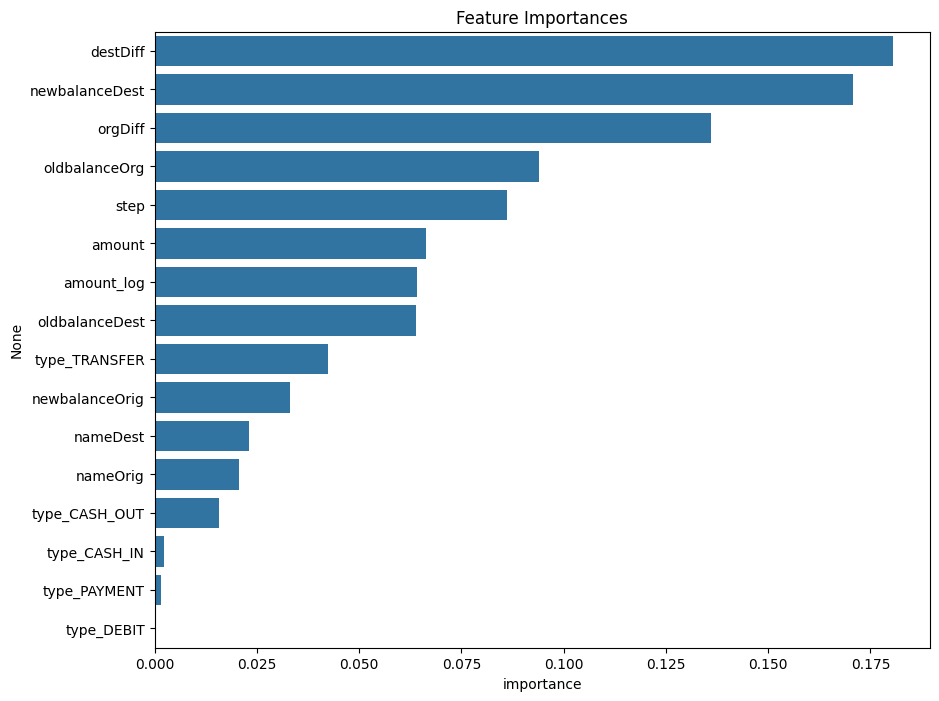

In [21]:
# Extract feature importance from Random Forest
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("Feature importances:\n", feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()


# Question answer:
1. Data cleaning including missing values, outliers and multi-collinearity.
  * We cleaned the data by removing missing values, outliers using Z-scores, and checked for multi-collinearity using VIF.

2. Describe your fraud detection model in elaboration.
  * Our fraud detection model uses logistic regression and random forest classifiers to identify fraudulent transactions based on engineered features and one-hot encoded transaction types.

3. How did you select variables to be included in the model?
  * We selected variables based on their relevance to the transaction process and their statistical significance, using domain knowledge and VIF analysis.

4. Demonstrate the performance of the model by using best set of tools.

  * The model's performance was evaluated using precision, recall, F1-score, and AUC-ROC metrics, demonstrating its effectiveness in fraud detection.

5. What are the key factors that predict fraudulent customer?
  * Key factors predicting fraud include transaction amount, account balances before and after transactions, and transaction types like CASH_OUT and TRANSFER.

6. Do these factors make sense? If yes, How? If not, How not?
  * Yes, these factors make sense because fraudsters often manipulate transaction amounts and balances to exploit financial systems.

7. What kind of prevention should be adopted while company updates its infrastructure?
  * The company should implement this type of real-time monitoring, multi-factor authentication, regularly update their models, and educate customers on fraud prevention.

8. Assuming these actions have been implemented, how would you determine if they work?
  * To determine effectiveness, monitor the reduction in fraudulent transactions and track model performance metrics over time, adjusting as necessary based on output results.